In [3]:
import tensorflow as tf
import numpy as np
import pickle
import os
import re
import matplotlib.pyplot as plt
from transformers import BertTokenizer, TFBertModel
from nltk.tokenize import sent_tokenize
import nltk
from IPython.display import display, HTML
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from collections import Counter

In [4]:
# Download NLTK resources if not already downloaded
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

In [35]:
class TextClassifier:
    def __init__(self, model_dir='saved_models_sentences_colab'):
        """
        Initialize the text classifier with pre-trained models.
        
        Args:
            model_dir (str): Directory containing saved models and configurations.
        """
        self.model_dir = model_dir
        
        # Load tokenizer
        self.tokenizer = BertTokenizer.from_pretrained(f"{model_dir}/tokenizer")
        
        # Load models
        custom_objects = {'TFBertModel': TFBertModel}
        with tf.keras.utils.custom_object_scope(custom_objects):
            self.bi_encoder_student_chatgpt = tf.keras.models.load_model(
                f"{model_dir}/bi_encoder_student_chatgpt.h5"
            )
            self.bi_encoder_only_chatgpt = tf.keras.models.load_model(
                f"{model_dir}/bi_encoder_only_chatgpt.h5"
            )
            self.classifier = tf.keras.models.load_model(
                f"{model_dir}/text_classifier.h5"
            )
        
        # Load scaler for stylometric features
        with open(f"{model_dir}/scaler_stylometric.pkl", "rb") as f:
            self.scaler = pickle.load(f)
            
        # Load reference embeddings
        with open(f"{model_dir}/reference_embeddings_1.pkl", "rb") as f:
            self.reference_embeddings_1 = pickle.load(f)
        
        with open(f"{model_dir}/reference_embeddings_2.pkl", "rb") as f:
            self.reference_embeddings_2 = pickle.load(f)
    
    def preprocess_text(self, text):
        """
        Preprocessing teks:
        - Mengubah teks menjadi huruf kecil.
        - Membagi teks menjadi kalimat (tokenisasi kalimat) menggunakan regex.
        - Tanda baca terakhir (., ?, !) tetap disertakan dalam hasil tokenisasi.

        Args:
            text (str): Teks input.

        Returns:
            list: Daftar kalimat yang telah diproses.
        """
        if not isinstance(text, str) or text.strip() == "":
            return []

        # Ubah teks menjadi huruf kecil dan hilangkan spasi di awal/akhir
        text = text.lower().strip()

        # Tokenisasi kalimat menggunakan regex
        sentences = re.findall(r'.+?[.!?](?=\s|$)', text)
        # Hapus elemen kosong dari hasil split (jika ada)
        sentences = [sentence.strip() for sentence in sentences if sentence.strip()]

        return sentences
    
    # Fungsi untuk tokenisasi teks
    def tokenize_text(self, texts):
        """
        Tokenisasi teks menggunakan tokenizer IndoBERT.
        
        Args:
            texts (list): Daftar teks yang akan di-tokenisasi.
            max_length (int): Panjang maksimum token.
            
        Returns:
            dict: Token hasil tokenisasi, termasuk input_ids dan attention_mask.
        """
        return self.tokenizer(
            texts,
            padding='max_length',
            truncation=True,
            max_length=128,
            return_tensors="tf"
        )
    
    def extract_stylometric_features(self, text):
        """
        Ekstraksi fitur stylometric dari teks:
        - Panjang kata rata-rata
        - Rasio kata unik
        - Rasio tanda baca
        - Panjang kalimat
        - Variasi panjang kata
        - Rasio kata fungsi
        - Jumlah koma
        - Jumlah titik

        Args:
            text (str): Input teks.

        Returns:
            dict: Fitur stylometric.
        """
        # Tokenisasi kata dan kalimat
        words = re.findall(r'\b\w+\b', text)  # Token kata
        sentences = re.split(r'[.!?]', text)  # Token kalimat

        # Basic features
        n_chars = len(text)
        n_words = len(words)
        avg_word_length = np.mean([len(word) for word in words]) if n_words > 0 else 0
        unique_word_ratio = len(set(words)) / n_words if n_words > 0 else 0

        # Syntactic features
        punctuation_count = len(re.findall(r'[.,!?;:]', text))
        punctuation_ratio = punctuation_count / n_chars if n_chars > 0 else 0

        # Variasi panjang kata
        word_length_std = np.std([len(word) for word in words]) if n_words > 0 else 0

        # Rasio kata fungsi
        function_words = {'a','ada','adalah','adanya','adapun','agak','agaknya','agar','akan','akankah','akhir',
                'akhiri','akhirnya','aku','akulah','amat','amatlah','anda','andalah','antar','antara',
                'antaranya','apa','apaan','apabila','apakah','apalagi','apatah','arti','artinya','asal',
                'asalkan','atas','atau','ataukah','ataupun','awal','awalnya','b','bagai','bagaikan',
                'bagaimana','bagaimanakah','bagaimanapun','bagainamakah','bagi','bagian','bahkan','bahwa',
                'bahwasannya','bahwasanya','baik','baiklah','bakal','bakalan','balik','banyak','bapak',
                'baru','bawah','beberapa','begini','beginian','beginikah','beginilah','begitu','begitukah',
                'begitulah','begitupun','bekerja','belakang','belakangan','belum','belumlah','benar',
                'benarkah','benarlah','berada','berakhir','berakhirlah','berakhirnya','berapa','berapakah',
                'berapalah','berapapun','berarti','berawal','berbagai','berdatangan','beri','berikan',
                'berikut','berikutnya','berjumlah','berkali-kali','berkata','berkehendak','berkeinginan',
                'berkenaan','berlainan','berlalu','berlangsung','berlebihan','bermacam','bermacam-macam',
                'bermaksud','bermula','bersama','bersama-sama','bersiap','bersiap-siap','bertanya',
                'bertanya-tanya','berturut','berturut-turut','bertutur','berujar','berupa','besar',
                'betul','betulkah','biasa','biasanya','bila','bilakah','bisa','bisakah','boleh','bolehkah',
                'bolehlah','buat','bukan','bukankah','bukanlah','bukannya','bulan','bung','c','cara',
                'caranya','cukup','cukupkah','cukuplah','cuma','d','dahulu','dalam','dan','dapat','dari',
                'daripada','datang','dekat','demi','demikian','demikianlah','dengan','depan','di','dia',
                'diakhiri','diakhirinya','dialah','diantara','diantaranya','diberi','diberikan','diberikannya',
                'dibuat','dibuatnya','didapat','didatangkan','digunakan','diibaratkan','diibaratkannya',
                'diingat','diingatkan','diinginkan','dijawab','dijelaskan','dijelaskannya','dikarenakan',
                'dikatakan','dikatakannya','dikerjakan','diketahui','diketahuinya','dikira','dilakukan',
                'dilalui','dilihat','dimaksud','dimaksudkan','dimaksudkannya','dimaksudnya','diminta',
                'dimintai','dimisalkan','dimulai','dimulailah','dimulainya','dimungkinkan','dini','dipastikan',
                'diperbuat','diperbuatnya','dipergunakan','diperkirakan','diperlihatkan','diperlukan',
                'diperlukannya','dipersoalkan','dipertanyakan','dipunyai','diri','dirinya','disampaikan',
                'disebut','disebutkan','disebutkannya','disini','disinilah','ditambahkan','ditandaskan',
                'ditanya','ditanyai','ditanyakan','ditegaskan','ditujukan','ditunjuk','ditunjuki','ditunjukkan',
                'ditunjukkannya','ditunjuknya','dituturkan','dituturkannya','diucapkan','diucapkannya',
                'diungkapkan','dong','dua','dulu','e','empat','enak','enggak','enggaknya','entah','entahlah',
                'f','g','guna','gunakan','h','hadap','hai','hal','halo','hallo','hampir','hanya','hanyalah',
                'hari','harus','haruslah','harusnya','helo','hello','hendak','hendaklah','hendaknya','hingga',
                'i','ia','ialah','ibarat','ibaratkan','ibaratnya','ibu','ikut','ingat','ingat-ingat','ingin',
                'inginkah','inginkan','ini','inikah','inilah','itu','itukah','itulah','j','jadi','jadilah',
                'jadinya','jangan','jangankan','janganlah','jauh','jawab','jawaban','jawabnya','jelas',
                'jelaskan','jelaslah','jelasnya','jika','jikalau','juga','jumlah','jumlahnya','justru',
                'k','kadar','kala','kalau','kalaulah','kalaupun','kali','kalian','kami','kamilah','kamu',
                'kamulah','kan','kapan','kapankah','kapanpun','karena','karenanya','kasus','kata','katakan',
                'katakanlah','katanya','ke','keadaan','kebetulan','kecil','kedua','keduanya','keinginan',
                'kelamaan','kelihatan','kelihatannya','kelima','keluar','kembali','kemudian','kemungkinan',
                'kemungkinannya','kena','kenapa','kepada','kepadanya','kerja','kesampaian','keseluruhan',
                'keseluruhannya','keterlaluan','ketika','khusus','khususnya','kini','kinilah','kira',
                'kira-kira','kiranya','kita','kitalah','kok','kurang','l','lagi','lagian','lah','lain',
                'lainnya','laku','lalu','lama','lamanya','langsung','lanjut','lanjutnya','lebih','lewat',
                'lihat','lima','luar','m','macam','maka','makanya','makin','maksud','malah','malahan',
                'mampu','mampukah','mana','manakala','manalagi','masa','masalah','masalahnya','masih',
                'masihkah','masing','masing-masing','masuk','mata','mau','maupun','melainkan','melakukan',
                'melalui','melihat','melihatnya','memang','memastikan','memberi','memberikan','membuat',
                'memerlukan','memihak','meminta','memintakan','memisalkan','memperbuat','mempergunakan',
                'memperkirakan','memperlihatkan','mempersiapkan','mempersoalkan','mempertanyakan','mempunyai',
                'memulai','memungkinkan','menaiki','menambahkan','menandaskan','menanti','menanti-nanti',
                'menantikan','menanya','menanyai','menanyakan','mendapat','mendapatkan','mendatang','mendatangi',
                'mendatangkan','menegaskan','mengakhiri','mengapa','mengatakan','mengatakannya','mengenai',
                'mengerjakan','mengetahui','menggunakan','menghendaki','mengibaratkan','mengibaratkannya',
                'mengingat','mengingatkan','menginginkan','mengira','mengucapkan','mengucapkannya','mengungkapkan',
                'menjadi','menjawab','menjelaskan','menuju','menunjuk','menunjuki','menunjukkan','menunjuknya',
                'menurut','menuturkan','menyampaikan','menyangkut','menyatakan','menyebutkan','menyeluruh',
                'menyiapkan','merasa','mereka','merekalah','merupakan','meski','meskipun','meyakini','meyakinkan',
                'minta','mirip','misal','misalkan','misalnya','mohon','mula','mulai','mulailah','mulanya','mungkin',
                'mungkinkah','n','nah','naik','namun','nanti','nantinya','nya','nyaris','nyata','nyatanya',
                'o','oleh','olehnya','orang','p','pada','padahal','padanya','pak','paling','panjang','pantas',
                'para','pasti','pastilah','penting','pentingnya','per','percuma','perlu','perlukah','perlunya',
                'pernah','persoalan','pertama','pertama-tama','pertanyaan','pertanyakan','pihak','pihaknya',
                'pukul','pula','pun','punya','q','r','rasa','rasanya','rupa','rupanya','s','saat','saatnya','saja',
                'sajalah','salam','saling','sama','sama-sama','sambil','sampai','sampai-sampai','sampaikan','sana',
                'sangat','sangatlah','sangkut','satu','saya','sayalah','se','sebab','sebabnya','sebagai',
                'sebagaimana','sebagainya','sebagian','sebaik','sebaik-baiknya','sebaiknya','sebaliknya',
                'sebanyak','sebegini','sebegitu','sebelum','sebelumnya','sebenarnya','seberapa','sebesar',
                'sebetulnya','sebisanya','sebuah','sebut','sebutlah','sebutnya','secara','secukupnya','sedang',
                'sedangkan','sedemikian','sedikit','sedikitnya','seenaknya','segala','segalanya','segera',
                'seharusnya','sehingga','seingat','sejak','sejauh','sejenak','sejumlah','sekadar','sekadarnya',
                'sekali','sekali-kali','sekalian','sekaligus','sekalipun','sekarang','sekaranglah','sekecil',
                'seketika','sekiranya','sekitar','sekitarnya','sekurang-kurangnya','sekurangnya','sela','selain',
                'selaku','selalu','selama','selama-lamanya','selamanya','selanjutnya','seluruh','seluruhnya',
                'semacam','semakin','semampu','semampunya','semasa','semasih','semata','semata-mata','semaunya',
                'sementara','semisal','semisalnya','sempat','semua','semuanya','semula','sendiri','sendirian',
                'sendirinya','seolah','seolah-olah','seorang','sepanjang','sepantasnya','sepantasnyalah',
                'seperlunya','seperti','sepertinya','sepihak','sering','seringnya','serta','serupa','sesaat',
                'sesama','sesampai','sesegera','sesekali','seseorang','sesuatu','sesuatunya','sesudah',
                'sesudahnya','setelah','setempat','setengah','seterusnya','setiap','setiba','setibanya',
                'setidak-tidaknya','setidaknya','setinggi','seusai','sewaktu','siap','siapa','siapakah',
                'siapapun','sini','sinilah','soal','soalnya','suatu','sudah','sudahkah','sudahlah','supaya',
                't','tadi','tadinya','tahu','tak','tambah','tambahnya','tampak','tampaknya','tandas','tandasnya',
                'tanpa','tanya','tanyakan','tanyanya','tapi','tegas','tegasnya','telah','tempat','tentang','tentu',
                'tentulah','tentunya','tepat','terakhir','terasa','terbanyak','terdahulu','terdapat','terdiri',
                'terhadap','terhadapnya','teringat','teringat-ingat','terjadi','terjadilah','terjadinya','terkira',
                'terlalu','terlebih','terlihat','termasuk','ternyata','tersampaikan','tersebut','tersebutlah',
                'tertentu','tertuju','terus','terutama','tetap','tetapi','tiap','tiba','tiba-tiba','tidak',
                'tidakkah','tidaklah','tiga','toh','tuju','tunjuk','turut','tutur','tuturnya','u','ucap','ucapnya',
                'ujar','ujarnya','umumnya','ungkap','ungkapnya','untuk','usah','usai','v','w','waduh','wah','wahai',
                'waktunya','walau','walaupun','wong','x','y','ya','yaitu','yakin','yakni','yang','z'}
        function_word_count = sum(1 for word in words if word.lower() in function_words)
        function_word_ratio = function_word_count / n_words if n_words > 0 else 0

        # Distribusi tanda baca
        punctuation_distribution = Counter(re.findall(r'[.,!?;:]', text))
        comma_count = punctuation_distribution.get(',', 0)
        period_count = punctuation_distribution.get('.', 0)

        return {
            'avg_word_length': avg_word_length,
            'unique_word_ratio': unique_word_ratio,
            'punctuation_ratio': punctuation_ratio,
            'sentence_length': n_words,
            'word_length_std': word_length_std,
            'function_word_ratio': function_word_ratio,
            'comma_count': comma_count,
            'period_count': period_count,
        }
    
    def generate_embeddings(self, tokens, model):
        """
        Generate embeddings for text.
        
        Args:
            tokens: Tokenized text.
            model: Bi-encoder model.
            
        Returns:
            tf.Tensor: Embeddings.
        """
        return model([tokens['input_ids'], tokens['attention_mask']])
    
    def compute_similarity_max(self, embedding, reference_embeddings):
        """
        Compute maximum similarity score.
        
        Args:
            embedding: Input embedding.
            reference_embeddings: Reference embeddings.
            
        Returns:
            float: Maximum similarity score.
        """
        # Normalize embeddings (L2 norm)
        embedding_norm = tf.nn.l2_normalize(embedding, axis=-1)
        reference_embeddings_norm = tf.nn.l2_normalize(reference_embeddings, axis=-1)
        
        # Compute cosine similarity
        similarities = tf.matmul(embedding_norm, tf.transpose(reference_embeddings_norm))
        similarities = tf.reshape(similarities, [-1])  # Flatten
        
        # Get maximum value
        max_similarity = tf.reduce_max(similarities).numpy()
        return max_similarity
    
    def classify_sentence(self, sentence):
        """
        Classify a single sentence.
        
        Args:
            sentence (str): Input sentence.
            
        Returns:
            tuple: Classification result (probability, class label, features).
        """
        # Preprocess sentence
        processed_sentences = self.preprocess_text(sentence)
        if not processed_sentences:
            return None, None, None
        
        # Join processed sentences into a single string
        processed_sentence = " ".join(processed_sentences)
        # Tokenize sentence
        tokens = self.tokenize_text([processed_sentence])
        
        # Generate embeddings
        embedding_1 = self.generate_embeddings(tokens, self.bi_encoder_student_chatgpt)
        embedding_2 = self.generate_embeddings(tokens, self.bi_encoder_only_chatgpt)
        
        # Extract stylometric features
        style_features = self.extract_stylometric_features(processed_sentence)
        style_features_df = np.array([[
            style_features['avg_word_length'],
            style_features['unique_word_ratio'],
            style_features['punctuation_ratio'],
            style_features['sentence_length'],
            style_features['word_length_std'],
            style_features['function_word_ratio'],
            style_features['comma_count'],
            style_features['period_count'],
        ]])
        
        # Normalize stylometric features
        normalized_features = self.scaler.transform(style_features_df)
        # print(self.reference_embeddings_1)
        # if 'embeddings' not in self.reference_embeddings_1:
        #     raise KeyError("The key 'embeddings' is missing in reference_embeddings_1.")

        # Compute similarity scores
        # 1. Similarity with Student (from Student_ChatGPT model)
        student_similarity = self.compute_similarity_max(
            embedding_1, 
            tf.convert_to_tensor(self.reference_embeddings_1['student']['embeddings'])
        )
        
        # 2. Similarity with ChatGPT (from Student_ChatGPT model)
        chatgpt_similarity = self.compute_similarity_max(
            embedding_1, 
            tf.convert_to_tensor(self.reference_embeddings_1['chatgpt']['embeddings'])
        )
        
        # 3. Similarity with ChatGPT Knowledge (from Only_ChatGPT model)
        chatgpt_knowledge_similarity = self.compute_similarity_max(
            embedding_2, 
            tf.convert_to_tensor(self.reference_embeddings_2['chatgpt_knowledge']['embeddings'])
        )
        
        # Combine similarity scores
        similarity_scores = np.array([[
            student_similarity,
            chatgpt_similarity,
            chatgpt_knowledge_similarity
        ]])
        
        # Prepare inputs for classifier
        inputs = {
            "bert_embedding_1": embedding_1.numpy(),
            "bert_embedding_2": embedding_2.numpy(),
            "stylometric_features": normalized_features,
            "similarity_score": similarity_scores
        }
        
        # Classify
        prediction = self.classifier.predict(inputs, verbose=0)[0][0]
        
        # Determine class (0: Human, 1: AI)
        class_label = "AI" if prediction > 0.5 else "Human"
        
        # Return prediction probability, class label, and features for visualization
        return prediction, class_label, {
            "student_similarity": student_similarity,
            "chatgpt_similarity": chatgpt_similarity,
            "chatgpt_knowledge_similarity": chatgpt_knowledge_similarity,
            "stylometric_features": style_features
        }
    
    def classify_text(self, text):
        """
        Classify text by splitting into sentences and classifying each one.
        
        Args:
            text (str): Input text.
            
        Returns:
            dict: Classification results including sentence-level classifications and overall statistics.
        """
        # Split text into sentences
        sentences = sent_tokenize(text)
        
        # Classify each sentence
        results = []
        for sentence in sentences:
            if sentence.strip():  # Skip empty sentences
                prob, label, features = self.classify_sentence(sentence)
                if prob is not None:
                    results.append({
                        "sentence": sentence,
                        "probability": prob,
                        "class": label,
                        "features": features
                    })
        
        # Calculate overall statistics
        total_sentences = len(results)
        ai_sentences = sum(1 for r in results if r["class"] == "AI")
        human_sentences = total_sentences - ai_sentences
        
        ai_percentage = (ai_sentences / total_sentences) * 100 if total_sentences > 0 else 0
        human_percentage = (human_sentences / total_sentences) * 100 if total_sentences > 0 else 0
        
        # Sort sentences by probability
        ai_sorted = sorted([r for r in results if r["class"] == "AI"], 
                          key=lambda x: x["probability"], reverse=True)
        human_sorted = sorted([r for r in results if r["class"] == "Human"], 
                             key=lambda x: 1 - x["probability"], reverse=True)
        
        # Get top 5 sentences for each class
        top_ai = ai_sorted[:5]
        top_human = human_sorted[:5]
        
        return {
            "sentences": results,
            "statistics": {
                "total_sentences": total_sentences,
                "ai_sentences": ai_sentences,
                "human_sentences": human_sentences,
                "ai_percentage": ai_percentage,
                "human_percentage": human_percentage
            },
            "top_ai": top_ai,
            "top_human": top_human
        }
    
    def visualize_results(self, text, results):
        """
        Visualize classification results with highlighted text and charts.
        
        Args:
            text (str): Original input text.
            results (dict): Classification results from classify_text.
            
        Returns:
            None: Displays visualization in the notebook.
        """
        # Create highlighted HTML
        highlighted_text = text
        
        # Sort sentences by length (longest first) to avoid replacing substrings
        sorted_sentences = sorted(results["sentences"], key=lambda x: len(x["sentence"]), reverse=True)
        
        for result in sorted_sentences:
            sentence = result["sentence"]
            if result["class"] == "AI":
                # Orange for AI
                replacement = f'<span style="background-color: rgba(255, 165, 0, 0.3);">{sentence}</span>'
            else:
                # Purple for Human
                replacement = f'<span style="background-color: rgba(128, 0, 128, 0.3);">{sentence}</span>'
            
            # Replace the sentence with highlighted version
            highlighted_text = highlighted_text.replace(sentence, replacement)
        
        # Display highlighted text
        display(HTML(f"<h3>Highlighted Text</h3><p>{highlighted_text}</p>"))
        
        # Create donut chart for overall statistics
        plt.figure(figsize=(10, 5))
        
        # Donut chart
        plt.subplot(1, 2, 1)
        labels = ['Human', 'AI']
        sizes = [results["statistics"]["human_percentage"], results["statistics"]["ai_percentage"]]
        colors = ['purple', 'orange']
        
        plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%',
                startangle=90, wedgeprops=dict(width=0.5))
        plt.axis('equal')
        plt.title('Classification Results')
        
        # Display top sentences
        plt.subplot(1, 2, 2)
        plt.axis('off')
        
        top_ai_text = "Top AI Sentences:\n"
        for i, sentence in enumerate(results["top_ai"]):
            if i < 5:  # Limit to 5
                prob_percent = sentence["probability"] * 100
                truncated = sentence["sentence"][:50] + "..." if len(sentence["sentence"]) > 50 else sentence["sentence"]
                top_ai_text += f"{i+1}. ({prob_percent:.1f}%) {truncated}\n"
        
        top_human_text = "\nTop Human Sentences:\n"
        for i, sentence in enumerate(results["top_human"]):
            if i < 5:  # Limit to 5
                prob_percent = (1 - sentence["probability"]) * 100
                truncated = sentence["sentence"][:50] + "..." if len(sentence["sentence"]) > 50 else sentence["sentence"]
                top_human_text += f"{i+1}. ({prob_percent:.1f}%) {truncated}\n"
        
        plt.text(0, 0.5, top_ai_text + top_human_text, fontsize=10, verticalalignment='center')
        
        plt.tight_layout()
        plt.show()
        
        # Display overall statistics
        print(f"Total Sentences: {results['statistics']['total_sentences']}")
        print(f"Human Sentences: {results['statistics']['human_sentences']} "
              f"({results['statistics']['human_percentage']:.1f}%)")
        print(f"AI Sentences: {results['statistics']['ai_sentences']} "
              f"({results['statistics']['ai_percentage']:.1f}%)")

# Example usage
def test_classifier(text):
    classifier = TextClassifier()
    results = classifier.classify_text(text)
    classifier.visualize_results(text, results)
    return results

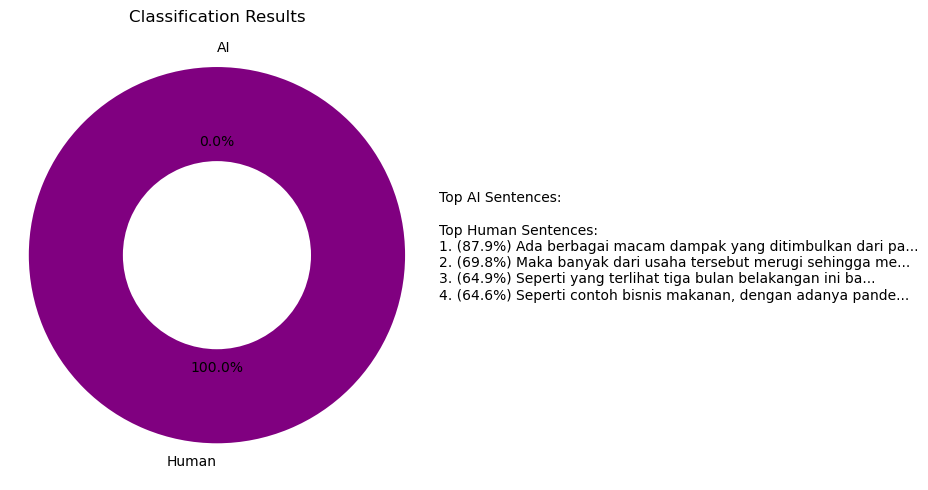

Total Sentences: 4
Human Sentences: 4 (100.0%)
AI Sentences: 0 (0.0%)


In [47]:
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=UserWarning, module='absl')
warnings.filterwarnings("ignore", category=Warning, module='tensorflow')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Test with sample text
if __name__ == "__main__":
    sample_text = input("Enter the text: ")
    results = test_classifier(sample_text)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.6.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


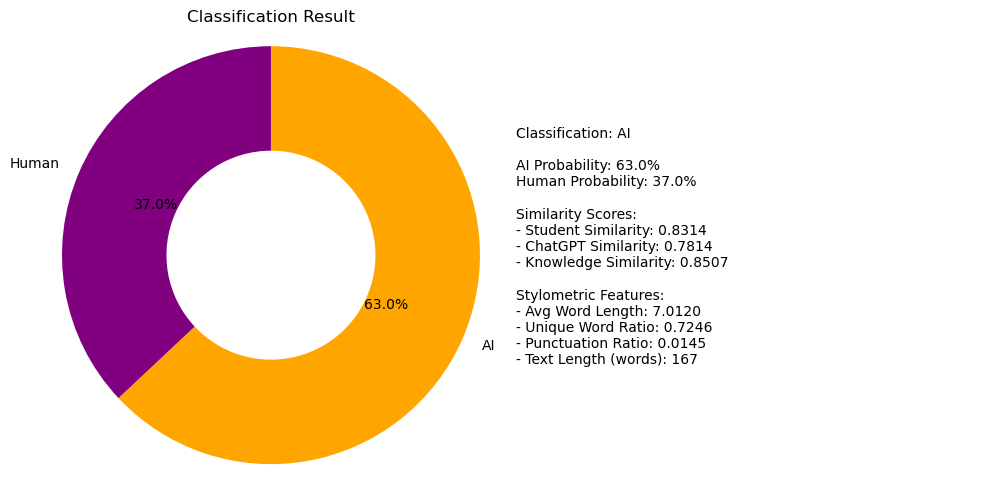

In [11]:
class TextClassifier:
    def __init__(self, model_dir='saved_models_colab'):
        """
        Initialize the text classifier with pre-trained models.
        
        Args:
            model_dir (str): Directory containing saved models and configurations.
        """
        self.model_dir = model_dir
        
        # Load tokenizer
        self.tokenizer = BertTokenizer.from_pretrained(f"{model_dir}/tokenizer")
        
        # Load models
        custom_objects = {'TFBertModel': TFBertModel}
        with tf.keras.utils.custom_object_scope(custom_objects):
            self.bi_encoder_student_chatgpt = tf.keras.models.load_model(
                f"{model_dir}/bi_encoder_student_chatgpt.h5"
            )
            self.bi_encoder_only_chatgpt = tf.keras.models.load_model(
                f"{model_dir}/bi_encoder_only_chatgpt.h5"
            )
            self.classifier = tf.keras.models.load_model(
                f"{model_dir}/text_classifier.h5"
            )
        
        # Load scaler for stylometric features
        with open(f"{model_dir}/scaler_stylometric.pkl", "rb") as f:
            self.scaler = pickle.load(f)
            
        # Load reference embeddings
        with open(f"{model_dir}/reference_embeddings_1.pkl", "rb") as f:
            self.reference_embeddings_1 = pickle.load(f)
        
        with open(f"{model_dir}/reference_embeddings_2.pkl", "rb") as f:
            self.reference_embeddings_2 = pickle.load(f)
    
    def preprocess_text(self, text):
        """
        Preprocess text by converting to lowercase and cleaning whitespace.
        
        Args:
            text (str): Input text.
            
        Returns:
            str: Preprocessed text.
        """
        if not isinstance(text, str) or text.strip() == "":
            return None
        
        # Clean text
        text = text.lower().strip()
        text = re.sub(r'\s+', ' ', text)  # Replace multiple whitespace with one space
        return text
    
    def tokenize_text(self, texts):
        """
        Tokenize text using the BERT tokenizer.
        
        Args:
            texts (list): List of texts to tokenize.
            max_length (int): Maximum token length.
            
        Returns:
            dict: Tokenized text including input_ids and attention_mask.
        """
        return self.tokenizer(
            texts,
            padding='max_length',
            truncation=True,
            max_length=256,
            return_tensors="tf"
        )
    
    def extract_stylometric_features(self, text):
        """
        Extract stylometric features from text.
        
        Args:
            text (str): Input text.
            
        Returns:
            dict: Stylometric features.
        """
        # Basic features
        n_chars = len(text)
        n_words = len(text.split())
        avg_word_length = n_chars / n_words if n_words > 0 else 0
        unique_word_ratio = len(set(text.split())) / n_words if n_words > 0 else 0
        
        # Syntactic features
        punctuation_ratio = len(re.findall(r'[.,!?;:]', text)) / n_chars if n_chars > 0 else 0
        
        return {
            'avg_word_length': avg_word_length,
            'unique_word_ratio': unique_word_ratio,
            'punctuation_ratio': punctuation_ratio,
            'sentence_length': n_words
        }
    
    def generate_embeddings(self, tokens, model):
        """
        Generate embeddings for text.
        
        Args:
            tokens: Tokenized text.
            model: Bi-encoder model.
            
        Returns:
            tf.Tensor: Embeddings.
        """
        return model([tokens['input_ids'], tokens['attention_mask']])
    
    def compute_similarity_max(self, embedding, reference_embeddings):
        """
        Compute maximum similarity score.
        
        Args:
            embedding: Input embedding.
            reference_embeddings: Reference embeddings.
            
        Returns:
            float: Maximum similarity score.
        """
        # Normalize embeddings (L2 norm)
        embedding_norm = tf.nn.l2_normalize(embedding, axis=-1)
        reference_embeddings_norm = tf.nn.l2_normalize(reference_embeddings, axis=-1)
        
        # Compute cosine similarity
        similarities = tf.matmul(embedding_norm, tf.transpose(reference_embeddings_norm))
        similarities = tf.reshape(similarities, [-1])  # Flatten
        
        # Get maximum value
        max_similarity = tf.reduce_max(similarities).numpy()
        return max_similarity
    
    def classify_text_as_whole(self, text):
        """
        Classify the entire text as a single unit without splitting into sentences.
        
        Args:
            text (str): Input text.
            
        Returns:
            dict: Classification result including probability and class label.
        """
        # Preprocess text
        processed_text = self.preprocess_text(text)
        if not processed_text:
            return None
        
        # Tokenize text
        tokens = self.tokenize_text([processed_text])
        
        # Generate embeddings
        embedding_1 = self.generate_embeddings(tokens, self.bi_encoder_student_chatgpt)
        embedding_2 = self.generate_embeddings(tokens, self.bi_encoder_only_chatgpt)
        
        # Extract stylometric features
        style_features = self.extract_stylometric_features(processed_text)
        style_features_df = np.array([[
            style_features['avg_word_length'],
            style_features['unique_word_ratio'],
            style_features['punctuation_ratio'],
            style_features['sentence_length']
        ]])
        
        # Normalize stylometric features
        normalized_features = self.scaler.transform(style_features_df)
        
        # Compute similarity scores
        # 1. Similarity with Student (from Student_ChatGPT model)
        student_similarity = self.compute_similarity_max(
            embedding_1, 
            tf.convert_to_tensor(self.reference_embeddings_1['student']['embeddings'])
        )
        
        # 2. Similarity with ChatGPT (from Student_ChatGPT model)
        chatgpt_similarity = self.compute_similarity_max(
            embedding_1, 
            tf.convert_to_tensor(self.reference_embeddings_1['chatgpt']['embeddings'])
        )
        
        # 3. Similarity with ChatGPT Knowledge (from Only_ChatGPT model)
        chatgpt_knowledge_similarity = self.compute_similarity_max(
            embedding_2, 
            tf.convert_to_tensor(self.reference_embeddings_2['chatgpt_knowledge']['embeddings'])
        )
        
        # Combine similarity scores
        similarity_scores = np.array([[
            student_similarity,
            chatgpt_similarity,
            chatgpt_knowledge_similarity
        ]])
        
        # Prepare inputs for classifier
        inputs = {
            "bert_embedding_1": embedding_1.numpy(),
            "bert_embedding_2": embedding_2.numpy(),
            "stylometric_features": normalized_features,
            "similarity_score": similarity_scores
        }
        
        # Classify
        prediction = self.classifier.predict(inputs, verbose=0)[0][0]
        
        # Determine class (0: Human, 1: AI)
        class_label = "AI" if prediction > 0.5 else "Human"
        
        # Return classification result
        return {
            "text": text,
            "probability": prediction,
            "class": class_label,
            "features": {
                "student_similarity": student_similarity,
                "chatgpt_similarity": chatgpt_similarity,
                "chatgpt_knowledge_similarity": chatgpt_knowledge_similarity,
                "stylometric_features": style_features
            }
        }
    
    def visualize_whole_text_result(self, result):
        """
        Visualize classification result for whole text.
        
        Args:
            result (dict): Classification result from classify_text_as_whole.
            
        Returns:
            None: Displays visualization in the notebook.
        """
        if result is None:
            print("No valid result to visualize.")
            return
        
        # Create highlighted HTML based on classification
        if result["class"] == "AI":
            # Orange for AI
            highlighted_text = f'<span style="background-color: rgba(255, 165, 0, 0.3);">{result["text"]}</span>'
        else:
            # Purple for Human
            highlighted_text = f'<span style="background-color: rgba(128, 0, 128, 0.3);">{result["text"]}</span>'
        
        # Display highlighted text
        display(HTML(f"<h3>Highlighted Text</h3><p>{highlighted_text}</p>"))
        
        # Create donut chart for classification result
        plt.figure(figsize=(10, 5))
        
        # Donut chart
        plt.subplot(1, 2, 1)
        labels = ['Human', 'AI']
        human_prob = (1 - result["probability"]) * 100
        ai_prob = result["probability"] * 100
        sizes = [human_prob, ai_prob]
        colors = ['purple', 'orange']
        
        plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%',
                startangle=90, wedgeprops=dict(width=0.5))
        plt.axis('equal')
        plt.title('Classification Result')
        
        # Display classification details
        plt.subplot(1, 2, 2)
        plt.axis('off')
        
        details_text = f"Classification: {result['class']}\n\n"
        details_text += f"AI Probability: {ai_prob:.1f}%\n"
        details_text += f"Human Probability: {human_prob:.1f}%\n\n"
        
        details_text += "Similarity Scores:\n"
        details_text += f"- Student Similarity: {result['features']['student_similarity']:.4f}\n"
        details_text += f"- ChatGPT Similarity: {result['features']['chatgpt_similarity']:.4f}\n"
        details_text += f"- Knowledge Similarity: {result['features']['chatgpt_knowledge_similarity']:.4f}\n\n"
        
        details_text += "Stylometric Features:\n"
        details_text += f"- Avg Word Length: {result['features']['stylometric_features']['avg_word_length']:.4f}\n"
        details_text += f"- Unique Word Ratio: {result['features']['stylometric_features']['unique_word_ratio']:.4f}\n"
        details_text += f"- Punctuation Ratio: {result['features']['stylometric_features']['punctuation_ratio']:.4f}\n"
        details_text += f"- Text Length (words): {result['features']['stylometric_features']['sentence_length']}\n"
        
        plt.text(0, 0.5, details_text, fontsize=10, verticalalignment='center')
        
        plt.tight_layout()
        plt.show()

# Example usage for whole text classification
def test_whole_text_classifier(text):
    classifier = TextClassifier()
    result = classifier.classify_text_as_whole(text)
    classifier.visualize_whole_text_result(result)
    return result

# Test with sample text
if __name__ == "__main__":
    sample_text = """
    Melatih literasi di era digital dapat dilakukan dengan banyak cara, apalagi dengan hadirnya teknologi canggih. Misalnya kita bisa menggunakan ponsel pintar untuk membuat target membaca buku setiap hari, menyetel pengingat saat jam literasi, dan bergabung dengan forum pecinta buku di media sosial. Sebaiknya bacalah buku yang sesuai dengan kesukaan kita terlebih dahulu. Tidak perlu memaksa untuk membaca genre buku yang tidak kita sukai karena akan ada suatu titik di mana kita merasa bosan terhadap suatu genre buku dan ingin mencoba bacaan baru. Semakin seseorang cinta membaca, maka semakin tinggi juga rasa ingin tahu mereka. Apabila kebiasaan ini telah dilakukan, tahap selanjutnya adalah mulai menulis dan menganalisis informasi. Tulislah hal yang membuat kita penasaran dalam sebuah bacaan lalu cobalah untuk menemukan dan menulis jawabannya. Misalnya ketika sedang membaca artikel mengenai covid, terdapat pernyataan bahwa virus covid telah bermutasi menjadi beberapa jenis yang lebih berbahaya. Kita bisa mulai mencari tahu mengapa sebuah virus bisa bermutasi, bagaimana cara mereka melakukan mutasi, dan mengapa mutasi virus disebut sebagai hal yang berbahaya.
    """
    
    result = test_whole_text_classifier(sample_text)
